# Neuromodulator Imaging Analysis

Here's some instructions from Alex on Friday 15/09:

- Simulate a train of APs of neurons: assuming a spike every second, then scale it to faster, then addd jitter/Poisson distribution — try drawing from an exp distribution or flip a coin each time
- Simulate relationship btn APs and DA release
- Simulate the signal delta F/ F

In this notebook, we will simulate the dynamics of neuromodulator concentration. For this we will start with:
- Simulation of a firing neuron, 
- Translate that to release of a neuromodulator. 
- Followed by a simulation of the signal $\Delta F/F$ produced by the changes in neuromodulator concentration.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp

### 1.Simulation of firing neuron

Here, we define a function that simulates the activity of one neuron and takes the number of timesteps and firing rate of the neuron as arguments.

In [2]:
# define function that simulates a firing neuron

# it takes the number of timesteps(ms) + firing rate (Hz) as the argument
def simulate_neuron(n_timesteps, firing_rate):
    
    # Start with an array of the timesteps that we're recording from
    firing_neuron = np.zeros(n_timesteps)

    # Then populate the array with signals - firing & not firing -- with a specific probability that you choose
    for i in range(n_timesteps):
        x = np.random.rand()

        # firing with specified prob at each time bin
        if x < 0.001*firing_rate:
            firing_neuron[i]=1

    # then make a plot of it!
    plt.plot(firing_neuron)
    plt.xlabel('timesteps')
    plt.ylabel('Neuron activity')
    plt.title('Neuron Activity over {} timesteps'.format(n_timesteps))
    plt.show()


    # check exactly how many spikes were produced: to see if it works
    n_spikes = np.size(np.nonzero(firing_neuron))

    # print simulated neuron summary:
    print('Simulated neuron({} Hz) with {} spikes in {} timesteps'.format(firing_rate, n_spikes, n_timesteps))
  

    return firing_neuron

# add the firing rate as an input
# add the number of spikes as output..you have a recorded from a neuron
# firing at a rate of 1Hz etc..(n_spikes was recorded across n_timesteps)


Now let's visualize our firing neuron to see if we simulated it correctly

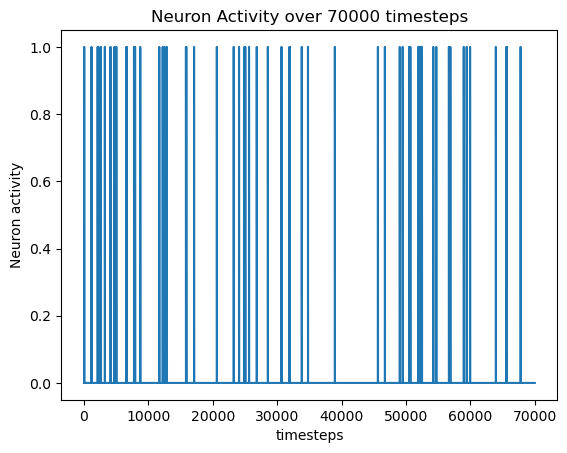

Simulated neuron(1 Hz) with 59 spikes in 70000 timesteps


In [3]:
# define the number of timesteps 70 seconds - 70000 milliseconds
# each timestep / bin is 1 ms wide

firing_neuron = simulate_neuron(70000,1)

Ok, look's like the neuron is firing as we expect it to over 70,000 timesteps.

Bonus: run this function several times and histogram the n_spikes to see if it's actually a gaussian w mean of 70 spikes.


### SIDE NOTE (extra -- not necessary to understand the rest of the simulation)
Below is an alternative approach to generating the spiking activity of a neuron, that makes use of the signal.unit_impulse feature of scipy.

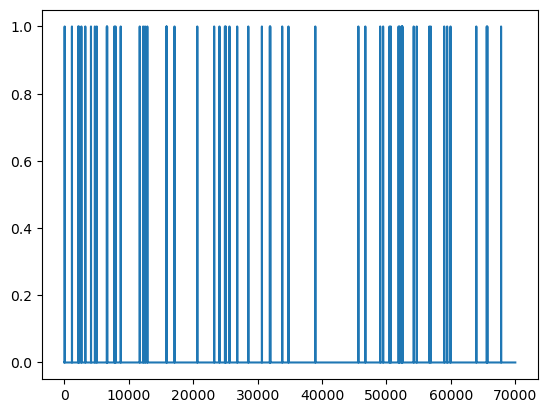

In [4]:
# timesteps where the neuron fired
firing_timesteps = np.nonzero(firing_neuron)

# generate visual representation of a train of spikes / I'll use this as the first approx. for the changes in [NM]
# ideally for the changes in [NM], we'd like to produce a chain of decaying exponents -- hopefully we produce them in a later cell

n_timesteps = 70000
spike_train = sp.signal.unit_impulse(n_timesteps,idx=firing_timesteps)

plt.plot(spike_train)

## 2.Neuromodulator concentration

Now let's simulate a simple case of neuromodulator release caused by our firing neuron. Here, we assume that the neuromodulator release occurs instantaneously, and that we are dealing with one compartment and there's no uptake. 

### Modelling [NM] using numerical integration

At each timestep:
- take previous value of [NM] ; nm_conc0 if timestep, t = 0
- update [NM] value: 
    - add the change in [NM], delta[NM] due to an action potential, if t==firing_timestep;
    - if it's not a firing timestep then subtract the 'infinitesimal' change in [NM], d[NM]/dt, at that timestep

In [14]:
# define the time constant tau -- play with this number
# find a way to like scroll thru different value of this number
# tau = 500 is a good estimate to be able to see the trend

# define the steady state value of nm_conc -- ask Kenta for this number


# define function that takes in an array of neuron activity and gives corresponding [NM]
def simulate_nm_conc(neuron_activity, tau, nm_conc0):


    # create array of [NM] with same size as neuron activity
    nm_conc = np.zeros(neuron_activity.size)

    # define delta_nm, the increase in [NM] due to a spike 
    # this will be a constant value  -- find the equation that gives this value (maybe eq 9?)
    delta_nm = 100
    


    # create a for-loop where we update the value of [NM] for current timestep
    for t in range(neuron_activity.size):
        
        # first timebin condition
        if t == 0 : 
            nm_conc[t] = nm_conc0 
        else: 
            nm_conc[t] = nm_conc[t-1]

        # update [NM] value

        # define d_nm/dt, the inifinitesimal decay in [NM] in one timestep 
        d_nm_dt =  (nm_conc[t]-nm_conc0)/tau

        # if there's a spike add Delta_nm else subtract d_nm/dt
        if neuron_activity[t]==1: nm_conc[t] = nm_conc[t] + delta_nm
        else: nm_conc[t] = nm_conc[t] - d_nm_dt 

    # plot the [NM] at all timesteps
    n_timesteps = neuron_activity.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    # plot the [NM] 
    plt.plot(t,nm_conc)
    plt.xlabel('time (ms)')
    plt.ylabel('NM concentration')
    plt.title('NM concentration across {} ms'.format(n_timesteps))
    plt.show()

    # return the array of the [NM]
    return nm_conc



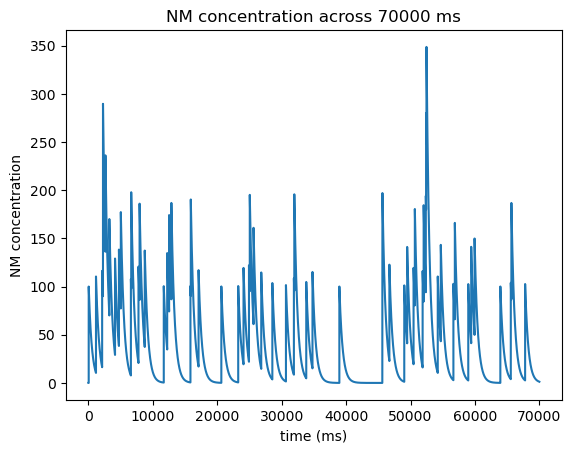

In [15]:
nm_conc = simulate_nm_conc(firing_neuron,500,0)

In [7]:
# Takes in the 1st and last timebins that will be the bounds of the plot
# Produces a plot within those timesteps
def plot_nm_conc(nm,start,stop):

    # define the timesteps to plot the [NM]
    timesteps = stop - start + 1
    t = np.linspace(start,stop,timesteps)

    # get that section of the [NM] array
    nm_section = nm[start:stop+1]

    # plot the [NM] 
    plt.plot(t,nm_section)
    plt.xlabel('time (ms)')
    plt.ylabel('NM concentration')
    plt.title('NM concentration from {} to {} ms'.format(start,stop))
    plt.show()

    #BONUS: plot the neuron activity correspoding to this time interval
    # right above the nm_conc plot



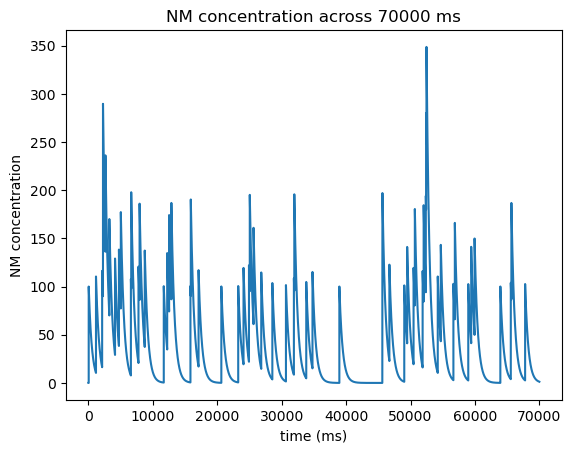

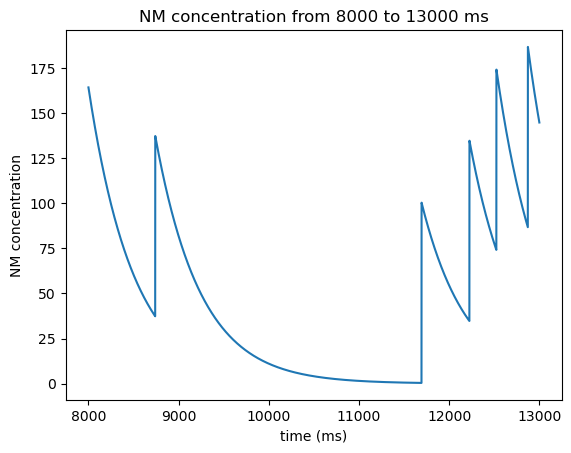

In [8]:
plot_nm_conc(simulate_nm_conc(firing_neuron,500,0), start = 8000,stop = 13000)

### 3.Flourescence Signal

Now, let's simulate the flourescence signal produced by the changes in the neuromodulator concentration,[NM]. This is described by eq. 3 in the calcium dynamics paper earlier mentioned: ** insert equation here

In [9]:
# GET ACTUAL VALUES FROM KENTA

# function takes in 3 constants used in the equation to calculate F from [NM]:
    # 1.The dissociation constant for the NM binding to the sensor,K_D
    # 2.The fluorescence when sensor is completely unbound to NM, F_max
    # 3.The fluorescence when sensor is completely bound to NM

def simulate_flourescence_signal(K_D, F_max, F_min, nm_conc):

    # define K_D prime as
    K_Dp = K_D*(F_max/F_min)

    # the initial/steady state concentration, [NM]i,0, of the neuromdultor
    # CONFIRM VALUE FROM KENTA
    nm_conc_0 = 0 

    # define the numerator and denominator
    numerator = (K_Dp + nm_conc)/(K_D + nm_conc)
    denominator = (K_Dp + nm_conc_0)/(K_D + nm_conc_0)

    # derive delta f/f0 by plugging in
    delta_ft_f0 = (numerator/denominator) - 1

    # create timesteps array for the plot
    n_timesteps = nm_conc.size
    t = np.linspace(0,n_timesteps-1,n_timesteps)

    # plot the normalized signal delta f/f0 at the different t
    plt.plot(t,delta_ft_f0)
    plt.xlabel('time(ms)')
    plt.ylabel('Delta F/F0')
    plt.title('Flourescence intensity signal over time')

    return delta_ft_f0


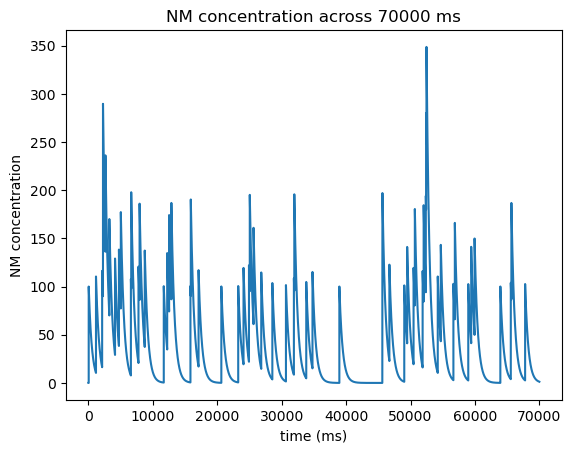

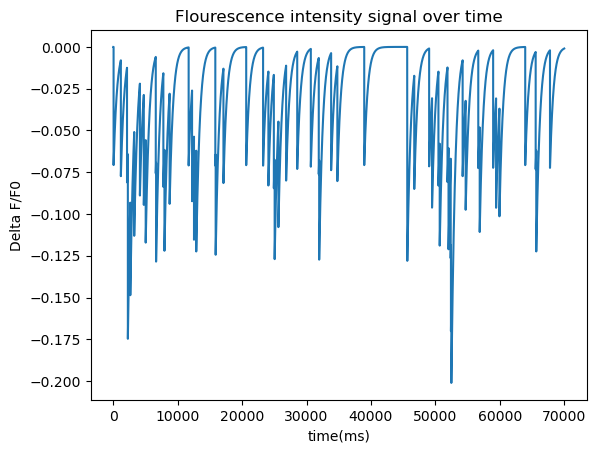

In [22]:
nm_conc_input = simulate_nm_conc(firing_neuron,500,0)
f_signal = simulate_flourescence_signal(K_D = 1000, F_max = 45, F_min = 10, nm_conc=nm_conc_input)

### Underlying relationship between the flourescence signal and [NM]

Now, let's see how changing the signal produced corresponds to [NM]. 

Text(0.5, 1.0, 'Relationship between f signal and [NM]')

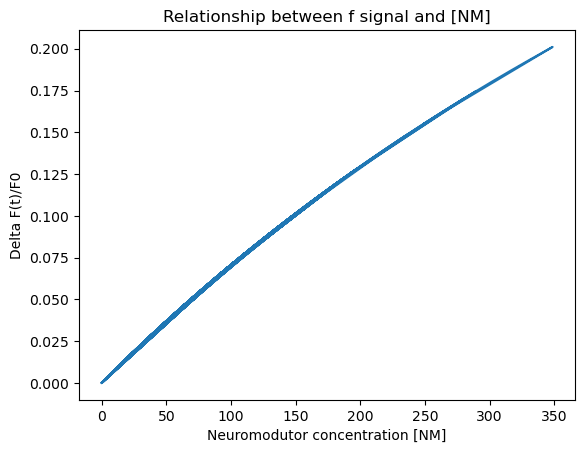

In [23]:
# plot the delta f vs the concentration

# here I've made a correction: the f values were negative(probably because of some constant)
# so i plotted -f

plt.plot(nm_conc,-f_signal)
plt.xlabel('Neuromodutor concentration [NM]')
plt.ylabel('Delta F(t)/F0')
plt.title('Relationship between f signal and [NM]')
